# Data Analysis on Quora dataset

## Introduction

In this notebook, we will analyze the [Quora dataset](https://www.kaggle.com/c/quora-question-pairs/data). The analysis will involve cleaning and preparing the data for the two algorithms we will be evaluating at the end of the notebook.

## Load essential libraries

In [1]:
# import libraries
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# to update later
from utils.utils import *

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import norm
from models.w2vec_model import *
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
#from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from pandas.tools.plotting import scatter_matrix

seed = 10

warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Quick look at the data

In [105]:
data = pd.read_csv('data/train.csv')

In [106]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Our data has 404,290 entries and 6 columns.<br >
The columns hold the following data:
<ol>
    <li>Id: a unique integer value that represents the id of each entry</li>
    <li>qid1: a unique integer value that represents the id of the question'1 text</li>
    <li>qid2: a unique integer value that represent the id of the question'2 text</li>
    <li>question1: a text that represents the first question</li>
    <li>question2: a text that represents the second question</li>
    <li>is_duplicate: a value of 0 or 1 that representes whether or not the two question means the same thing</li>
</ol>

## Check and remove missing entries

In the previous section, our data have some missing entries in 'question2'. Let's remove those entries.

In [108]:
# let's check missing question entries
q1_nan = sum(data.question1.isnull())
q2_nan = sum(data.question2.isnull())
print('Question 1 has {0} missing values'.format(q1_nan))
print('Question 2 has {0} missing values'.format(q2_nan))

Question 1 has 0 missing values
Question 2 has 2 missing values


In [109]:
# remove those entries
data.drop(data[data.question2.isnull()].index, inplace=True)

In [110]:
# check
data[data.question2.isnull()]

,id,qid1,qid2,question1,question2,is_duplicate


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404288 entries, 0 to 404289
Data columns (total 6 columns):
id              404288 non-null int64
qid1            404288 non-null int64
qid2            404288 non-null int64
question1       404288 non-null object
question2       404288 non-null object
is_duplicate    404288 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


## Check for duplicates

In this section, we will check for duplicate questions. Checking for duplicates is important because our model won't learn if we have lots of repeated entries.

In [112]:
# check for duplicate question ids

duplicated_id = data.duplicated('id', keep=False)
duplicated_qid1 = data.duplicated('qid1', keep=False)
duplicated_qid2 = data.duplicated('qid2', keep=False)

sum_dup_id = sum(duplicated_id)
sum_dup_qid1 = sum(duplicated_qid1)
sum_dup_qid2 = sum(duplicated_qid2)


print("The number of duplicated 'id' is: {0}".format(sum_dup_id))
print("The number of duplicated 'qid1' is {0}".format(sum_dup_qid1))
print("The number of duplicated 'qid2' is {0}".format(sum_dup_qid2))
print("Proportion of duplicated 'qid1' is {0}%".format(round(sum_dup_qid1/data.shape[0] * 100, 2) ))
print("Proportion of duplicated 'qid2' is {0}%".format(round(sum_dup_qid2/data.shape[0] * 100, 2)))



The number of duplicated 'id' is: 0
The number of duplicated 'qid1' is 167707
The number of duplicated 'qid2' is 150555
Proportion of duplicated 'qid1' is 41.48%
Proportion of duplicated 'qid2' is 37.24%


We have roughly 41.48% duplicate qid1 and 37.24 duplicate qid2. Next let's check if those ids have the same text data.

In [113]:
q1_dup = data[duplicated_qid1].sort_values('qid1')
q2_dup = data[duplicated_qid2].sort_values('qid2')

In [114]:
q1_dup.head(6)

,id,qid1,qid2,question1,question2,is_duplicate
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
359232,359232,3,488853,What is the story of Kohinoor (Koh-i-Noor) Dia...,Could India keep the Koh-I-Noor safe?,0
263614,263614,3,380197,What is the story of Kohinoor (Koh-i-Noor) Dia...,What are some interesting facts about Kohinoor...,0
184732,184732,3,282170,What is the story of Kohinoor (Koh-i-Noor) Dia...,Is it possible to melt down diamonds?,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
126071,126071,9,109465,"Which one dissolve in water quikly sugar, salt...","Which freezes faster, sugar water or salt wat...",0


In [115]:
q2_dup.head(6)

,id,qid1,qid2,question1,question2,is_duplicate
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
402369,402369,38436,18,"When do you use ""into"" instead of ""in to""?","When do you use ""&"" instead of ""and""?",0
65735,65735,114035,26,Is there a way to make learning physics easier?,How can you make physics easy to learn?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
27051,27051,50277,28,What is your first sexual experience?,What was your first sexual experience?,1


We have checked and seen that the duplicate question ids have the same text data. Next,  let's look at the pair of duplicate questions.

In [116]:
# check if we have duplicate question ids pairs
dup_pair = data.duplicated(['qid1', 'qid2'], keep=False) 
data[dup_pair]

,id,qid1,qid2,question1,question2,is_duplicate


Even though we have duplicate qid1 and qid2, we do not have duplicate pairs. Which is good for our training.

## Text Analysis

In this section we will perform text analysis on our data. The text analysis will involve :
<ol>
    <li>Removing all non-alphanumeric characters</li>
</ol>

In [117]:
# Remove all non-alphanumeric token in our corpus
data['question1'] = data['question1'].apply(clean_str)
data['question2'] = data['question2'].apply(clean_str)

In [118]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor ( koh i noor ) ...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely ? how can i sol...,find the remainder when math 23 24 math i...,0
4,4,9,10,"which one dissolve in water quikly sugar , sa...",which fish would survive in salt water ?,0


In [119]:
for i in range(5):
    print("question 1: {0}".format(data['question1'][i]))
    print("question 2: {0}".format(data['question2'][i]))
    print("is duplicate: {0}".format(data['is_duplicate'][i]))
    print()

question 1: what is the step by step guide to invest in share market in india ?
question 2: what is the step by step guide to invest in share market ?
is duplicate: 0

question 1: what is the story of kohinoor  ( koh i noor )  diamond ?
question 2: what would happen if the indian government stole the kohinoor  ( koh i noor )  diamond back ?
is duplicate: 0

question 1: how can i increase the speed of my internet connection while using a vpn ?
question 2: how can internet speed be increased by hacking through dns ?
is duplicate: 0

question 1: why am i mentally very lonely ?  how can i solve it ?
question 2: find the remainder when  math 23  24   math  is divided by 24 , 23 ?
is duplicate: 0

question 1: which one dissolve in water quikly sugar ,  salt ,  methane and carbon di oxide ?
question 2: which fish would survive in salt water ?
is duplicate: 0



## Visualization

In this section, we will perform some visualizations

In [120]:
d = data.groupby(['is_duplicate'])[['id']].count()

In [121]:
d

,id
is_duplicate,
0,255025
1,149263


In [122]:
d['id']/data.shape[0] * 100

is_duplicate
0    63.080032
1    36.919968
Name: id, dtype: float64

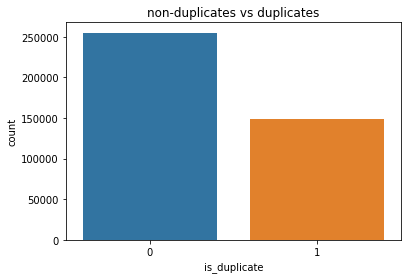

In [123]:
sns.countplot(x='is_duplicate', data=data)
plt.title('non-duplicates vs duplicates')
plt.show()

Our dataset has roughly 63% of nonduplicate entries and 37% of duplicate entries. Next, let's look at the questions length distribution.

In [124]:
data['question1'] = data['question1'].apply(lambda x: x.split())
data['question2'] = data['question2'].apply(lambda x: x.split())

In [125]:
data['q1_len'] = data['question1'].apply(len)
data['q2_len'] = data['question2'].apply(len)

In [126]:
d_1 = data['q1_len'] == 0
d_2 = data['q2_len'] == 0

ind_1 = data[d_1].index
ind_2 = data[d_2].index
ind = ind_1.append(ind_2)

In [127]:
ind

Int64Index([3306, 190570, 290090, 301583, 20072, 144343, 384293], dtype='int64')

In [128]:
# remove empty questions
data = data.drop(ind)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
0,0,1,2,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0,15,13
1,1,3,4,"[what, is, the, story, of, kohinoor, (, koh, i...","[what, would, happen, if, the, indian, governm...",0,13,18
2,2,5,6,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0,15,11
3,3,7,8,"[why, am, i, mentally, very, lonely, ?, how, c...","[find, the, remainder, when, math, 23, 24, mat...",0,13,15
4,4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water, ?]",0,16,8


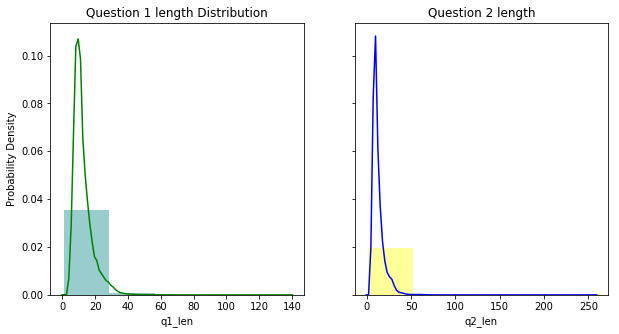

In [129]:
# what is the age distribution?
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
sns.distplot(data['q1_len'], hist_kws={'color': 'Teal'},bins=5, kde_kws={'color': 'green'}, ax=axs[0], label='question1');
axs[0].set(title='Question 1 length Distribution')
axs[0].set(ylabel='Probability Density')
sns.distplot(data['q2_len'], bins=5,hist_kws={'color': 'yellow'}, kde_kws={'color': 'blue'}, ax=axs[1], label='question2' );
axs[1].set(title='Question 2 length')
plt.show()

Both sentences are right skewed.

In [130]:
data.drop(['qid1', 'qid2','id','q1_len', 'q2_len'], axis=1, inplace=True)

In [131]:
data.shape

(404281, 3)

## Prepare our data for a convolutional neural network model

In this section, we will make our data suitable for a convolutional neural network archittecture. We will perform the following steps:
<ol>
    <li>Pad our sentences with empty string to make them have the same length. </li>
    <li>Build our word representations model and replace all question text with their corresponding vector space representations.</li>
    <li>Split our data into training data and test data.</li>
</ol>

### 1. Pad sentences

In other for our sentences to all have the same length, we have padded with empty string all sentences that have a number of tokens less than 40, and we have taken only the first 40 tokens for sentences that have more than 40 tokens.

In [132]:
data_cnn = data.copy()

In [133]:
data_cnn.head()

,question1,question2,is_duplicate
0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0
1,"[what, is, the, story, of, kohinoor, (, koh, i...","[what, would, happen, if, the, indian, governm...",0
2,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0
3,"[why, am, i, mentally, very, lonely, ?, how, c...","[find, the, remainder, when, math, 23, 24, mat...",0
4,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water, ?]",0


In [134]:
# take only the first words 
data_cnn['question1'] = data_cnn['question1'].apply(lambda x: x + ['']*(40 - len(x)) if len(x) < 40 else x[:40])
data_cnn['question2'] = data_cnn['question2'].apply(lambda x: x + ['']*(40 - len(x)) if len(x) < 40 else x[:40])

In [135]:
data_cnn.head()

,question1,question2,is_duplicate
0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv...",0
1,"[what, is, the, story, of, kohinoor, (, koh, i...","[what, would, happen, if, the, indian, governm...",0
2,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,...",0
3,"[why, am, i, mentally, very, lonely, ?, how, c...","[find, the, remainder, when, math, 23, 24, mat...",0
4,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water,...",0


### 2. Word representations

In [136]:
# get all the questions
questions = data_cnn['question1'].append(data_cnn['question2'], ignore_index=True).tolist()

In [137]:
# build word2vec model using only 100 features
num_features = 100
min_word_count = 1
num_workers = multiprocessing.cpu_count()
context_size = 5
downsampling = 1e-3
seed = 10
sg=1

In [138]:
model = Word2VecModel()
model.create_w2v_model(questions, num_features, min_word_count, context_size,
                         sg, downsampling, seed)

In [139]:
data_cnn['question1'] = data_cnn['question1'].apply(lambda x: get_w2v_vector(model._model, x, vector_size=100))
data_cnn['question2'] = data_cnn['question2'].apply(lambda x: get_w2v_vector(model._model, x, vector_size=100))

### 3. Split data

In this section, we will split the data into training and test sets. We won't use all the data, we will take all the records with 'is_duplicate' value of 1 and randomly select records with 'is_duplicate' value of 0. The final dataset will have the same proportion of duplicate and non-duplicate data.

In [140]:
# get the shape
data_cnn.shape

(404281, 3)

In [142]:
# split a data into duplicate and not duplicate
data_dup = data_cnn[data_cnn['is_duplicate'] == 1]
data_nondup = data_cnn[data_cnn['is_duplicate'] == 0]

In [143]:
# get the number of duplicate 
number_elt = data_dup.shape[0]

In [144]:
# sample non duplicate data so that duplicate and non duplicate have the same size
non_dup = data_nondup.sample(n=number_elt, random_state=seed)

In [145]:
data_cnn_final = pd.concat([non_dup, data_dup])

In [146]:
# split the data into training and test dataset 
train, test = train_test_split(data_cnn_final, test_size=0.1, random_state=seed)

In [147]:
print(train.shape)
print(test.shape)

(268673, 3)
(29853, 3)


In [148]:
train.to_pickle('data/quora_cnn_train.pickle')
test.to_pickle('data/quora_cnn_test.pickle')

Our data is ready to be used in a convolutional neural network archittecture.

## Prepare data for xgboost model

In this section, we will prepare our data to be suitable for XGBoost model.
We will perform the following step:
<ol>
    <li>Prepare our text data by removing punctuation and stopwords.</li>
    <li>Perform additional features engineering.</li>
    <li>Split the data into train, test</li>
</ol>


### 1. Remove punctuations and stopwords

In [35]:
# get a copy 
data_xgb = data.copy()

In [36]:
# remove punctuation in our corpus
data_xgb['question1'] = data_xgb['question1'].apply(lambda x: remove_punctuation(x))
data_xgb['question2'] = data_xgb['question2'].apply(lambda x: remove_punctuation(x))

In [37]:
# remove stopwords in our corpus
data_xgb['question1'] = data_xgb['question1'].apply(remove_stopwords)
data_xgb['question2'] = data_xgb['question2'].apply(remove_stopwords)

In [38]:
data_xgb.head()

,question1,question2,is_duplicate
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,"[story, kohinoor, koh, noor, diamond]","[would, happen, indian, government, stole, koh...",0
2,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0
3,"[mentally, lonely, solve]","[find, remainder, math, 23, 24, math, divided,...",0
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


### 2. Features engineering

We will perform the following features engineering on our data:
<ol>
<li>Similarity score between the two questions of each record.</li>
<li>Number of words in question 1.</li>
<li>Number of words in question 2.</li>
<li>Number of unique token in question 1.</li>
<li>Number of unique token in question 2.</li>
<li>Number of unique shared token between question 1 and question 2.</li>
</ol>

#### 2.1 Similarity score

In [39]:
##prepare the data to build the LSA model
data1 = data_xgb.question1
data2 = data_xgb.question2
data_q1 = []
data_q2 = []
q1_q2 = []
for d in data1:
    d1 = ' '.join(d)
    data_q1.append(d1)
    
for d in data2:
    d2 = ' '.join(d)
    data_q2.append(d2)
# our document set consist of all the questions: questions1 and questions2    
q1_q2 = data_q1 + data_q2

In [40]:
svd_clf = make_pipeline(TfidfVectorizer(min_df=1),
                               TruncatedSVD(algorithm='arpack', n_components=100, random_state=seed))
svd_clf

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...vd', TruncatedSVD(algorithm='arpack', n_components=100, n_iter=5, random_state=10,
       tol=0.0))])

In [41]:
# fit the model
svd_clf.fit(q1_q2)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...vd', TruncatedSVD(algorithm='arpack', n_components=100, n_iter=5, random_state=10,
       tol=0.0))])

In [42]:
# apply trainsform to question1 and question 2 to get SVD vectors
questions1_transform = svd_clf.transform(data_q1)
questions2_transform = svd_clf.transform(data_q2)

In [43]:
# similarity score
sim = similarity(questions1_transform, questions2_transform)


In [44]:
data_xgb['similarity'] = sim

In [45]:
data_xgb.head()

,question1,question2,is_duplicate,similarity
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0,0.279266
1,"[story, kohinoor, koh, noor, diamond]","[would, happen, indian, government, stole, koh...",0,0.001116
2,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0,0.476311
3,"[mentally, lonely, solve]","[find, remainder, math, 23, 24, math, divided,...",0,0.132588
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0,0.022397


#### 2.2: Other feature engineering

In [46]:
# other feature engineering
### number of word in question 1
data_xgb['q1_len'] = data_xgb['question1'].apply(len)
### number of word in question 2
data_xgb['q2_len'] = data_xgb['question2'].apply(len)
### number of unique word in question 1
data_xgb['q1_voc_len'] = data_xgb['question1'].apply(lambda x: len(list(set(x))))
### number of unique word in question 2
data_xgb['q2_voc_len'] = data_xgb['question2'].apply(lambda x: len(list(set(x))))
### number of unique word in both question 1 and question 2
data_xgb['shared_token_len'] = data_xgb.apply(lambda row: len(list(set(row['question1']) & set(row['question2']))), axis=1 )

In [47]:
data_xgb.head()

,question1,question2,is_duplicate,similarity,q1_len,q2_len,q1_voc_len,q2_voc_len,shared_token_len
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0,0.279266,7,6,6,5,5
1,"[story, kohinoor, koh, noor, diamond]","[would, happen, indian, government, stole, koh...",0,0.001116,5,10,5,10,4
2,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0,0.476311,6,5,6,5,2
3,"[mentally, lonely, solve]","[find, remainder, math, 23, 24, math, divided,...",0,0.132588,3,9,3,6,0
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0,0.022397,10,5,10,5,2


In [48]:
# remove nan
# remove NAN iN similarity
ind_sim = data_xgb[data_xgb.similarity.isnull()].index

In [49]:
len(ind_sim)

253

In [50]:
data_xgb.drop(ind_sim, inplace=True)

In [51]:
data_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404028 entries, 0 to 404289
Data columns (total 9 columns):
question1           404028 non-null object
question2           404028 non-null object
is_duplicate        404028 non-null int64
similarity          404028 non-null float64
q1_len              404028 non-null int64
q2_len              404028 non-null int64
q1_voc_len          404028 non-null int64
q2_voc_len          404028 non-null int64
shared_token_len    404028 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 30.8+ MB


In [53]:
# drop the column we won't need
data_xgb.drop(['question1', 'question2'], axis=1, inplace=True)

In [54]:
data_xgb.head()

,is_duplicate,similarity,q1_len,q2_len,q1_voc_len,q2_voc_len,shared_token_len
0,0,0.279266,7,6,6,5,5
1,0,0.001116,5,10,5,10,4
2,0,0.476311,6,5,6,5,2
3,0,0.132588,3,9,3,6,0
4,0,0.022397,10,5,10,5,2


### Data distribution

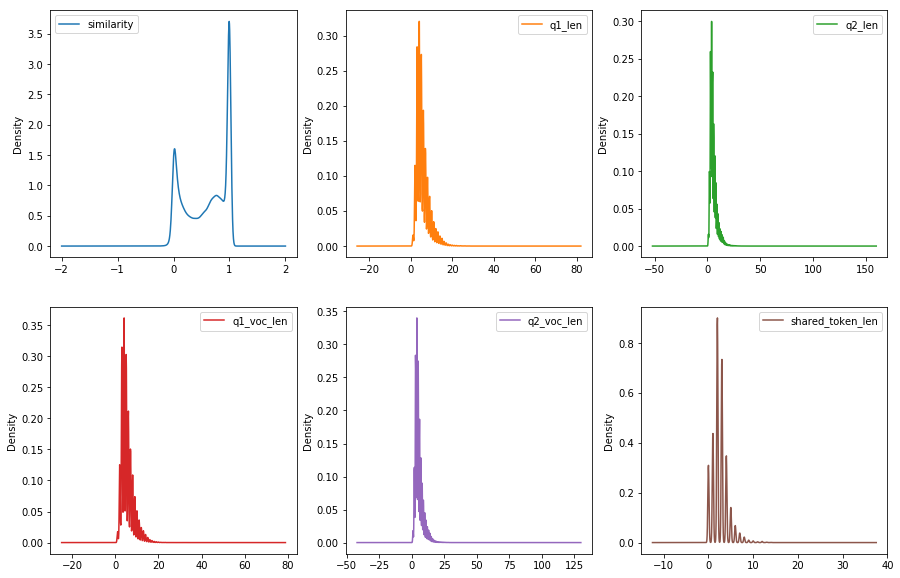

In [55]:
data_xgb[['similarity', 'q1_len', 'q2_len', 'q1_voc_len', 'q2_voc_len', 'shared_token_len']].plot(kind= 'density',
                                                                                                    figsize=(15, 10),
                                                                                                    subplots=True, layout=(2,3),
                                                                                                    sharex=False, sharey=False)
plt.show()

### Correlation

In [56]:
data_xgb_features = data_xgb[['similarity', 'q1_len', 'q2_len', 'q1_voc_len', 'q2_voc_len', 'shared_token_len']]

In [57]:
names = list(data_xgb_features.columns.values)

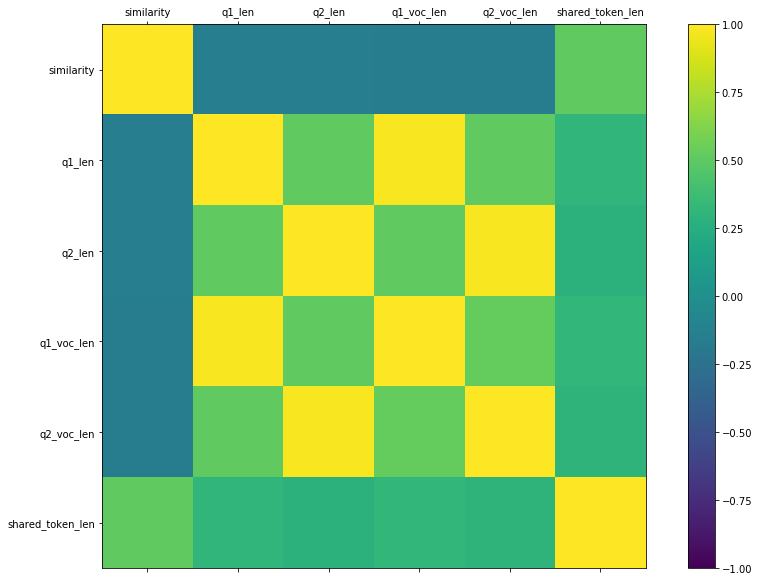

In [60]:
#correlation matrix
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(data_xgb_features.corr(),vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [61]:
# xgboost tree
xgb_model = XGBClassifier()
xgb_model.fit(data_xgb.drop('is_duplicate',1), data_xgb.is_duplicate)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

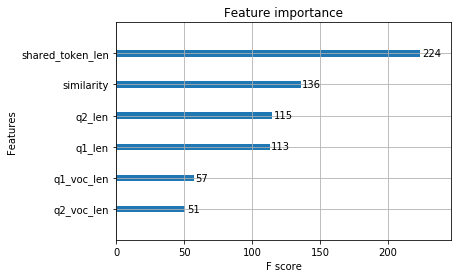

In [66]:
# todo importance figure
plot_importance(xgb_model)
plt.show()

In [67]:
# split the data into training and test dataset 
train_xgb, test_xgb = train_test_split(data_xgb, test_size=0.1, random_state=seed)

In [68]:
### save data for xgboost learning
train_xgb.to_pickle('data/quora_xgb_train.pickle')
test_xgb.to_pickle('data/quora_xgb_test.pickle')

In this section, we have prepared our dataset for the xgboost learning model. 

## XGboost model results

In [69]:
import pandas as pd

In [70]:
results = pd.read_csv('results.csv')

In [71]:
results.head()

,max_depth,mean_test_score,mean_train_score,n_estimators,learning_rate
0,8,0.632535,0.691859,950,0.1
1,8,0.632256,0.693540,1000,0.1
2,8,0.632141,0.695346,1050,0.1
3,10,0.630692,0.720166,950,0.1
4,10,0.630145,0.722614,1000,0.1


In [72]:
res = pd.melt(results, id_vars=['max_depth', 'n_estimators', 'learning_rate'], value_vars=['mean_test_score', 'mean_train_score'])

In [73]:
res.head()

,max_depth,n_estimators,learning_rate,variable,value
0,8,950,0.1,mean_test_score,0.632535
1,8,1000,0.1,mean_test_score,0.632256
2,8,1050,0.1,mean_test_score,0.632141
3,10,950,0.1,mean_test_score,0.630692
4,10,1000,0.1,mean_test_score,0.630145


### Plot results

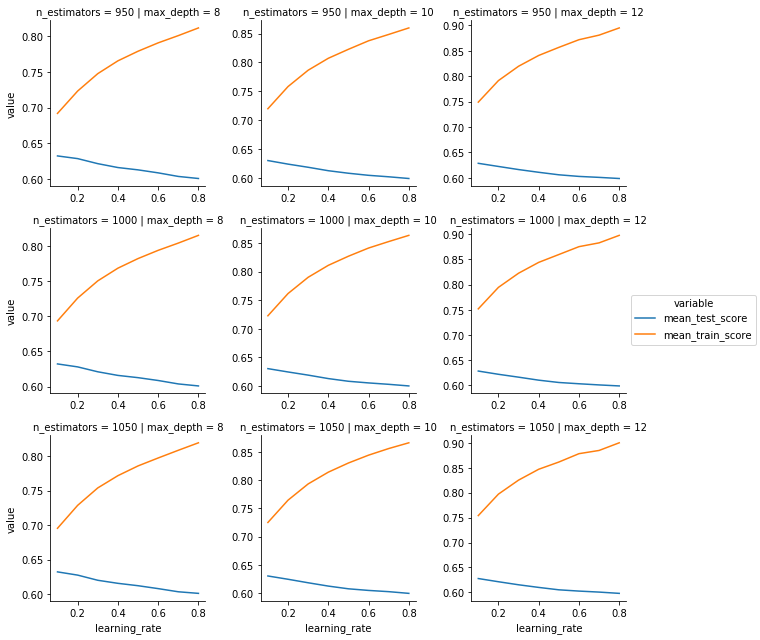

In [88]:
g = sns.FacetGrid(res, col="max_depth",  row="n_estimators", hue='variable', sharex=False, sharey=False)
g = g.map(plt.plot, "learning_rate", "value").add_legend()
plt.show()

The best params have the following:
best params {'max_depth': 8, 'n_estimators': 950, 'learning_rate': 0.1}

### Final XGBoost model

In [83]:
data_train = pd.read_pickle('data/quora_xgb_train.pickle').values
X_train = data_train[:, 1:]
y_train = data_train[:, 0]

In [84]:
data_train = pd.read_pickle('data/quora_xgb_test.pickle').values
X_test = data_train[:, 1:]
y_test = data_train[:, 0]

In [85]:
model = XGBClassifier(max_depth=8, n_estimators=950, learning_rate=0.1, random_state=seed)

In [86]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=950,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [90]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f1 = f1_score(y_test, predictions)
print("F1 Score: %.2f%%" % (f1 * 100.0))

F1 Score: 64.50%


## Convolutional neural network results

### Result visualization

In [5]:
def make_fbeta(threshold_shift):
    def fbeta(y_true, y_pred, beta=1):
        '''
        Compute fbeta score.
        :param y_true: y_true
        :param y_pred: predicted value
        :param threshold_shift: threshold
        :param beta: beta value
        :return: fbeta score
    
    '''
    # just in case of hipster activation at the final layer
        y_pred = K.clip(y_pred, 0, 1)
        y_true = K.clip(y_true, 0, 1)
    
    # shifting the prediction threshold from .5 if needed
        y_pred_bin = K.round(y_pred + threshold_shift)
    
        tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
        fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
    
        beta_squared = beta ** 2
        return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return fbeta

In [6]:
fbeta01 = make_fbeta(0.1)
fbeta02 = make_fbeta(0.2)
fbeta03 = make_fbeta(0.3)
fbeta04 = make_fbeta(0.4)
fbeta00 = make_fbeta(0.0)
fbeta_minus01 = make_fbeta(-0.1)
fbeta_minus02 = make_fbeta(-0.2)
fbeta_minus03 = make_fbeta(-0.3)
fbeta_minus04 = make_fbeta(-0.4)

In [7]:
from models.cnn_model import CnnModel
from utils import *
import pandas as pd

filter_size = 512
strides = (1, 1)
padding = 'VALID'
embedding_len = 100
sentence_len = 40
activation = 'relu'
filters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
bias = True
k_initialization = 'glorot_uniform'
b_initialization = 'zeros'
input_shape = (sentence_len, embedding_len, 1)

In [8]:
cnn_model = CnnModel.from_weights('models/model.weights.best.hdf5', filter_size, strides, padding, embedding_len, activation,filters, k_initialization, b_initialization, input_shape, bias)
cnn_model.summary()
cnn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=[fbeta_minus04, fbeta_minus03, fbeta_minus02, fbeta_minus01,fbeta00, fbeta01, fbeta02, fbeta03, fbeta04 ])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 40, 100, 1)    0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 40, 100, 1)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 39, 1, 512)    102912      input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 38, 1, 512)    154112      input_1[0][0]           

In [9]:
test = pd.read_pickle('data/quora_cnn_test.pickle')

In [10]:
sentence_1_test = test.question1.tolist()
sentence_2_test = test.question2.tolist()
y_test = test.is_duplicate.tolist()
question_1_test, question_2_test, y_test = reshape_data(sentence_1_test, sentence_2_test, y_test)

In [11]:
scores = cnn_model.evaluate([question_1_test, question_2_test], y_test)

In [12]:
scores

[0.13803778676073367,
 0.80163690647898467,
 0.83399159012897262,
 0.83609674125485522,
 0.8263953027903157,
 0.8125622029384848,
 0.79445643268134514,
 0.7700613053728379,
 0.73822953360957544,
 0.69621932087274263]

In [13]:
scores_final = scores[1:]

In [14]:
shift = [-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4]

In [15]:
df = pd.DataFrame({'threshold_shift':shift, 'fbeta':scores_final})

In [16]:
df

,fbeta,threshold_shift
0,0.801637,-0.4
1,0.833992,-0.3
2,0.836097,-0.2
3,0.826395,-0.1
4,0.812562,0.0
5,0.794456,0.1
6,0.770061,0.2
7,0.738230,0.3
8,0.696219,0.4


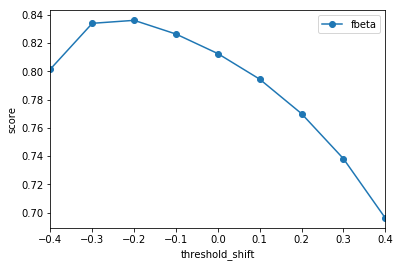

In [18]:
df.plot(x='threshold_shift', y='fbeta', marker='o')
plt.ylabel('score')
plt.show()

In [19]:
from models.w2vec_model import Word2VecModel
w2vmodel = Word2VecModel.from_file('models/model.w2v')

In [20]:
def build_vector(sentence):
    s = clean_str(sentence)
    w =  remove_punctuation(s.split())
    e = remove_stopwords(w)
    e = e + ['']*(40 - len(e)) if len(e) < 40 else e[:40]
    arr = w2vmodel.get_w2v_vector(e, 100)
    return arr

In [21]:
def predict_sentence(model, question_1, question_2):
    q1 = build_vector(question_1)
    q2 =  build_vector(question_2)
    q1 = q1.reshape(q1.shape + (1,))
    q2 = q2.reshape(q2.shape + (1,))
    q1 = np.expand_dims(q1, axis=0)
    q2 = np.expand_dims(q2, axis=0)
    score = model.predict([q1, q2])
    print('!!!!!!!---- Predicting Similarity ----!!!!!!!')
    print('Sentence 1:' + question_1)
    print('Sentence 2:' + question_2)
    if score[0] < 0.7:
        print('Both sentences are not similar with score: {}'.format(score[0]))
    else:
        print('Both sentences are similar with score: {}'.format(score[0]))

In [52]:
sentence_1 = 'how to become a US citizen ?'
sentence_2 = 'how to become a French citizen ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:how to become a US citizen ?
Sentence 2:how to become a French citizen ?
Both sentences are not similar with score: [ 0.23872811]


In [53]:
sentence_1 = 'how to become a US citizen ?'
sentence_2 = 'how to become a EU citizen ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:how to become a US citizen ?
Sentence 2:how to become a EU citizen ?
Both sentences are not similar with score: [ 0.00465195]


In [54]:
sentence_1 = 'how to become an Italian citizen?'
sentence_2 = 'how to become a EU citizen ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:how to become an Italian citizen?
Sentence 2:how to become a EU citizen ?
Both sentences are not similar with score: [ 0.32664385]


In [56]:
sentence_1 = 'how to become a EU citizen ?'
sentence_2 = 'how to become a EU citizen ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:how to become a EU citizen ?
Sentence 2:how to become a EU citizen ?
Both sentences are similar with score: [ 0.99999994]


In [57]:
sentence_1 = 'What is the best city to visit in europe ?'
sentence_2 = 'What is the best city to visit in EU ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:What is the best city to visit in europe ?
Sentence 2:What is the best city to visit in EU ?
Both sentences are similar with score: [ 0.75177467]


In [58]:
sentence_1 = 'What is the best city to visit in ASIA ?'
sentence_2 = 'What is the best city to visit in africa ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:What is the best city to visit in ASIA ?
Sentence 2:What is the best city to visit in africa ?
Both sentences are not similar with score: [ 0.67797351]


In [59]:
sentence_1 = 'How to add 2 numbers ?'
sentence_2 = 'how to perform addition on 2 numbers ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:How to add 2 numbers ?
Sentence 2:how to perform addition on 2 numbers ?
Both sentences are similar with score: [ 0.8533954]


In [60]:
sentence_1 = 'How to become a data scientist ?'
sentence_2 = 'how to be a data scientist ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:How to become a data scientist ?
Sentence 2:how to be a data scientist ?
Both sentences are not similar with score: [ 0.56243247]


In [61]:
sentence_1 = 'How to become a data scientist ?'
sentence_2 = 'how to become a data analyst ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:How to become a data scientist ?
Sentence 2:how to become a data analyst ?
Both sentences are similar with score: [ 0.71512794]


In [62]:
sentence_1 = 'what is the daily routine of teachers ?'
sentence_2 = 'what teachers do everyday ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:what is the daily routine of teachers ?
Sentence 2:what teachers do everyday ?
Both sentences are not similar with score: [ 0.12048633]


In [63]:
sentence_1 = 'what most americans eat in the morning ?'
sentence_2 = ' what most americans eat for breakfast ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:what most americans eat in the morning ?
Sentence 2: what most americans eat for breakfast ?
Both sentences are not similar with score: [ 0.68511772]


In [64]:
sentence_1 = 'what is the popular dish in Italy ?'
sentence_2 = 'why italian eat pasta everyday ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:what is the popular dish in Italy ?
Sentence 2:why italian eat pasta everyday ?
Both sentences are not similar with score: [ 0.00035387]


In [65]:
sentence_1 = 'why germans love beer ?'
sentence_2 = 'why italians love coffee ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:why germans love beer ?
Sentence 2:why italians love coffee ?
Both sentences are not similar with score: [ 0.42894882]


In [66]:
sentence_1 = 'why rome is one of the dirtiest city in north italy ?'
sentence_2 = 'why germany is one of the cleanest country in europe ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:why rome is one of the dirtiest city in north italy ?
Sentence 2:why germany is one of the cleanest country in europe ?
Both sentences are not similar with score: [ 0.15353528]


In [69]:
sentence_1 = 'who is the president of the free world?'
sentence_2 = 'who is the president of the united states ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:who is the president of the free world?
Sentence 2:who is the president of the united states ?
Both sentences are similar with score: [ 0.73722506]


In [83]:
sentence_1 = 'who is the leader of the free world ?'
sentence_2 = 'who is Donald J Trump  ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:who is the leader of the free world ?
Sentence 2:who is Donald J Trump  ?
Both sentences are not similar with score: [ 0.044797]


In [84]:
sentence_1 = 'who is Barack Obama ?'
sentence_2 = 'who is the president of the united states ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:who is Barack Obama ?
Sentence 2:who is the president of the united states ?
Both sentences are similar with score: [ 0.96072662]


In [86]:
sentence_1 = 'who is Donald J Trump ?'
sentence_2 = 'who is the president of the united states ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:who is Donald J Trump ?
Sentence 2:who is the president of the united states ?
Both sentences are similar with score: [ 0.97374898]


In [88]:
sentence_1 = 'who is EMMANUEL MACRON ?'
sentence_2 = 'who is the president of the united states ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:who is EMMANUEL MACRON ?
Sentence 2:who is the president of the united states ?
Both sentences are not similar with score: [ 0.02487888]


In [89]:
sentence_1 = 'who is EMMANUEL MACRON ?'
sentence_2 = 'who is the president of FRANCE ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:who is EMMANUEL MACRON ?
Sentence 2:who is the president of FRANCE ?
Both sentences are not similar with score: [ 0.00053833]


In [90]:
sentence_1 = 'who is FRANCOIS Hollande ?'
sentence_2 = 'who is the president of FRANCE ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:who is FRANCOIS Hollande ?
Sentence 2:who is the president of FRANCE ?
Both sentences are not similar with score: [ 0.00047577]


In [91]:
sentence_1 = 'who is john doe ?'
sentence_2 = 'who is the president of the united states ?'
predict_sentence(cnn_model, sentence_1, sentence_2)

!!!!!!!---- Predicting Similarity ----!!!!!!!
Sentence 1:who is john doe ?
Sentence 2:who is the president of the united states ?
Both sentences are not similar with score: [ 0.09765264]
